In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import pprint
import matplotlib.pyplot as plt

from load_data import load_data
Airport_Network = load_data()
from load_data import load_df_airport
df_airport = load_df_airport()
from load_data import add_exogenous_feature
from utils import plt_directed

## Weighted Version 

A weighted version of our graph has also been created to suppress the multiplicity of the edges. By doing that, the **weight of an edge shows the number of routes** (strict definition of routes: Routes, where one carrier operates both its own and codeshare flights, are **listed only once.**) **on that connection in the given direction** and our Airport_Network graph becomes a **weighted directed graph.**

To achieve this weighted version, thanks to pandas we loaded the raw data from *openflights/routes.dat.txt* in a dataframe. The groupby operation was used to group each route having exactly the same Source_Node and Target_Node. Thanks to that, the columns Weight, corresponding to duplicated ties of each route summed up was created. Then, by using the function *from_pandas_dataframe* the new weighted version of the graph was created. In this new network, **the weight of an edge represents the number of routes on that connection in the given direction, which means the number of routes from airport A to airport B.**

In [2]:
df_duplicates = pd.read_csv('./openflights/routes.dat.txt', header = None)
# Rename columns to give meaningful names
df_duplicates = df_duplicates.rename(columns = {3:'Source_Node', 5:'Target_Node', 7:'Weight'})
df_duplicates = df_duplicates[['Source_Node', 'Target_Node', 'Weight']]
# Define a weight of 1 for each node
df_duplicates['Weight'] = 1
# Summation of the duplicate edges by storing the sum values in the 'weight' column
df_weighted = df_duplicates.groupby(['Source_Node', 'Target_Node']).sum().reset_index()
df_weighted.head()

,Source_Node,Target_Node,Weight
0,1,2,1
1,1,3,1
2,1,4,1
3,1,5,2
4,10,5446,1


We check if the size of our df_weighted network is the same as the one announces in the documentation. In fact, it's said that in this network, 37.595 edges should be unique and that 67,663 edges in total should be existing. This unique edges number should correspond to the number of lines in our *df_weighted* dataframe as we drop duplicates by transferring the information to the weights. In addition, the total number of edges should correspond to the number of line of the raw dataframe which is *df_duplicates*. As you can see below this is the case.

In [3]:
df_weighted.shape

(37505, 3)

In [4]:
df_duplicates.shape

(67663, 3)

In [5]:
df_weighted['Weight'].sum()

67663

We again add the external information to the weighted graph with the same function stored in the *utils.py* file:

In [6]:
# Add exogenous information on the weighted version of the graph
df_airport_tmp = df_airport[['Airport_ID', 'City', 'Country', 'Latitude', 'Longitude']].rename(columns = {'Airport_ID':'Source_Node'} )
df_airport_tmp['Source_Node'] = df_airport_tmp['Source_Node'].astype(str)
df_complete = df_weighted.merge(df_airport_tmp, how = 'inner', on = 'Source_Node')
df_complete.head()

,Source_Node,Target_Node,Weight,City,Country,Latitude,Longitude
0,1,2,1,Goroka,Papua New Guinea,-6.081690,145.391998
1,1,3,1,Goroka,Papua New Guinea,-6.081690,145.391998
2,1,4,1,Goroka,Papua New Guinea,-6.081690,145.391998
3,1,5,2,Goroka,Papua New Guinea,-6.081690,145.391998
4,10,5446,1,Thule,Greenland,76.531197,-68.703201



Airport_Network Informations Summary:
Name: 
Type: DiGraph
Number of nodes: 3334
Number of edges: 37505
Average in degree:  11.2493
Average out degree:  11.2493 


Information of the node labeled 1 :
{ 'City': 'Goroka',
  'Country': 'Papua New Guinea',
  'Latitude': -6.0816898345900015,
  'Longitude': 145.391998291}

Information of the edge labeled 1 :
{'2': {'Weight': 1}, '3': {'Weight': 1}, '4': {'Weight': 1}, '5': {'Weight': 2}}


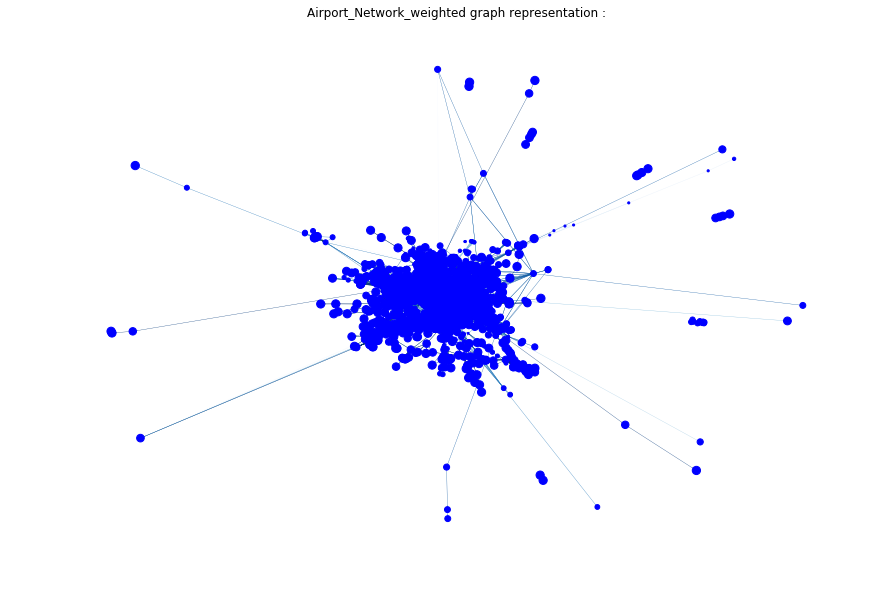

In [7]:
df_weighted['Source_Node'] = df_weighted['Source_Node'].astype(str)
df_weighted['Target_Node'] = df_weighted['Target_Node'].astype(str)
df_airport['Airport_ID'] = df_airport['Airport_ID'].astype(str)

# Load the network.
Airport_Network_weighted = nx.from_pandas_edgelist(df_weighted, 'Source_Node', 'Target_Node', edge_attr='Weight', create_using=nx.DiGraph())
Airport_Network_weighted = add_exogenous_feature(Airport_Network_weighted, df_airport)

pp = pprint.PrettyPrinter(indent=2)

# Print out the summary information of the graphs
print('\nAirport_Network Informations Summary:')
print(nx.info(Airport_Network_weighted),'\n')

# Example of the different attributes of an node
print('\nInformation of the node labeled 1 :')
pp.pprint(Airport_Network_weighted.node['1'])
# Example of the different attributes of an edge
print('\nInformation of the edge labeled 1 :')
pp.pprint(dict(Airport_Network_weighted.adj['1']))

# Plot the graph thanks to the function define above
plt_directed(Airport_Network_weighted, 'Airport_Network_weighted graph representation :')

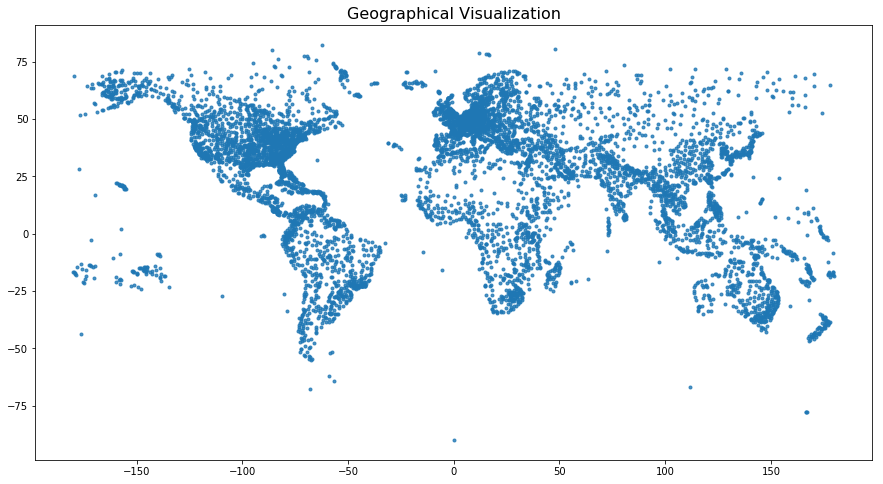

In [8]:
import matplotlib.pyplot as plt
def pair_elements(*args):
    output = []
    for node_id in args[0].keys():
        output.append(tuple(i[node_id] for i in args))
    return np.array(output)

values = pair_elements(
    nx.get_node_attributes(Airport_Network, "Latitude"),
    nx.get_node_attributes(Airport_Network, "Longitude"),
)

plt.figure(figsize=(15, 8))
plt.scatter(values[:, 1], values[:, 0], alpha=0.8, marker='.')
plt.title("Geographical Visualization", fontsize=16)
plt.show()

***As a conclusion of this part, one new graph was created called Airport_Network_weighted: this is a directed weighted graph where the weight of an edge represents the number of routes on that connection in the given direction. Each node has information about the airport it represents. This graph will be the object of our study. The geographic representation is meaningful and the entire subset of edges is represented. Not all the airports present in the database are taking into account: the only ones analyzed are the ones for which edges exist and link them to other nodes.***